<a href="https://colab.research.google.com/github/deepesh321/BERT_document_classification/blob/master/Bert_document_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install transformers

     |████████████████████████████████| 573kB 9.7MB/s 
     |████████████████████████████████| 3.7MB 79kB/s 
     |████████████████████████████████| 870kB 54.0MB/s 
     |████████████████████████████████| 1.0MB 36.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=10ee80f178b2a931f42b5433fc3042a8726a565e21beb046985cda7ae7ed7c59
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [ ]:
import urllib
import os

if not os.path.exists('./data/'):
  os.mkdir('./data/')

files=[
       ('./data/attack_annotated_comments.tsv','https://ndownloader.figshare.com/files/7554634'),
       ('./data/attack_annotations.tsv','https://ndownloader.figshare.com/files/7554637')
]

for (filename,url) in files:
  if not os.path.exists(filename):
    print('Downloading',filename)
    urllib.request.urlretrieve(url,filename)
    print('Downloaded')


Downloaded
Downloaded


In [ ]:
import pandas as pd
comments=pd.read_csv('./data/attack_annotated_comments.tsv',sep='\t',index_col=0)
annotations=pd.read_csv('./data/attack_annotations.tsv',sep='\t')

In [ ]:
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [ ]:
comments[['comment','split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [ ]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Label a comment as attack if majority of annotators did so
labels=annotations.groupby('rev_id')['attack'].mean()>0.5
#join commnets and labels
comments['attack']=labels

In [ ]:
#Remove Newline and Tab Tokens 
comments['comment']=comments['comment'].apply(lambda x:x.replace('NEWLINE_TOKEN',' '))
comments['comment']=comments['comment'].apply(lambda x:x.replace('TAB_TOKEN',' '))

In [ ]:
#divide the dataset into training and testing
train_comments=comments.query("split=='train'")
test_comments=comments.query("split=='test'")

In [ ]:
import textwrap
import random
wrapper=textwrap.TextWrapper(width=80)
attack_examples=train_comments.query('attack')['comment']
for i in range(10):
  j=random.choice(attack_examples.index)
  print('')
  print(wrapper.fill(attack_examples[j]))
  print('')


` ==Israel Idonije== ok, dude, you obviously don't no anything about the
I-Train, he NEVER PLAYED IN NFL EUROPE! Look at my references, he was on the
Bears practice squad during the first half of the NFL season, and was promoted
to the roster on the 2nd half, stop reverting back to Berlin Thunder, and don't
give me the ``false edit`` bullshit. Please reply  `


  ::Fuck up.


` ::::::::``And I hate everything to do with China`` What's with all the hate?
I, believe it or not, do not hate Georgians. Just Saakashvili. He's an asshole.
`


`   ==Chicken-Ryu?== All the ip addresses you used so far, for your (sneaky)
vandalist actions and keeping the edit war alive:  *  *  *  *  *  *  *  *  *  *
*  *  *  (This list is probably not even complete!!)  In stead of hiding behind
all kinds of different ip addresses, you could at least have the guts and the
decency to insult me using your own name!?! Or are you chickin'??? Maybe you can
change the name of your style (Genseiryu-Butokukai) into Chic

In [ ]:
total_comments=len(comments)
num_attacks=len(comments.query('attack'))
print('fraction_of_attacks',num_attacks/total_comments)

fraction_of_attacks 0.11729268797900988


In [ ]:
print('fraction_of_non_attack_comments',1-num_attacks/total_comments)

fraction_of_non_attack_comments 0.8827073120209901


In [ ]:
#Tokenize
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

In [ ]:
#Tokenizing all the taining comments
import numpy as np
input_ids=[]
lengths=[]
for sent in train_comments.comment:
  encode_sent=tokenizer.encode(sent,add_special_tokens=True) #encoding and adding special tokens [cls],[sep]
  input_ids.append(encode_sent)
  lengths.append(len(encode_sent))

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1057 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

In [ ]:
labels=train_comments.attack.to_numpy().astype(int)
print('no. of attack labels',np.sum(labels))
print('no. of non_attack_labels',len(labels)-np.sum(labels))

no. of attack labels 8079
no. of non_attack_labels 61447


In [ ]:
print('min_length',min(lengths))
print('max_lengths',max(lengths))
print('median_lengths',np.median(lengths))

min_length 2
max_lengths 9861
median_lengths 52.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0, 0.5, 'no of labels')

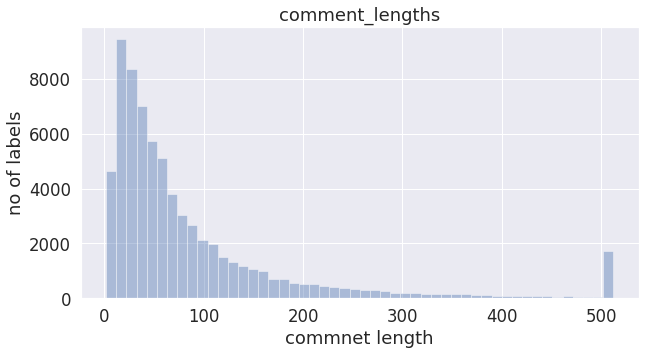

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(font_scale=1.5)
plt.rcParams['figure.figsize']=(10,5)
lengths=[min(l,512) for l in lengths]
sns.distplot(lengths,kde=False,rug=False)
plt.title('comment_lengths')
plt.xlabel('commnet length')
plt.ylabel('no of labels')

In [ ]:
num_truncated=lengths.count(512)
print('fraction of truncated sentence',num_truncated/len(lengths))

fraction of truncated sentence 0.0239910249403101


In [ ]:
#Padding
from keras.preprocessing.sequence import pad_sequences
max_len=128
input_ids=pad_sequences(input_ids,maxlen=max_len,dtype='long',value=0,padding='post',truncating='post')


Using TensorFlow backend.


In [ ]:
attention_mask=[]
for sent in input_ids:
  attn_mask=[int(token_id>0) for token_id in sent]
  attention_mask.append(attn_mask)

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs,validation_inputs,train_labels,validation_labels=train_test_split(input_ids,labels,random_state=2018,test_size=0.1)
train_masks,validation_masks,_,_=train_test_split(attention_mask,labels,random_state=2018,test_size=0.1)

In [ ]:
train_inputs=torch.tensor(train_inputs)
validation_inputs=torch.tensor(validation_inputs)

train_labels=torch.tensor(train_labels)
validation_labels=torch.tensor(validation_labels)

train_masks=torch.tensor(train_masks)
validation_masks=torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

batch_size=32

#create the dataloader for trainig data
train_data=TensorDataset(train_inputs,train_labels,train_masks)
train_sampler=RandomSampler(train_data)
train_dataloader=DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

#create the dataloader for validation data
val_data=TensorDataset(validation_inputs,validation_labels,validation_masks)
val_sampler=RandomSampler(val_data)
val_dataloader=DataLoader(val_data,sampler=val_sampler,batch_size=batch_size)


In [ ]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

model=BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2,output_attentions=False,output_hidden_states=False)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer=AdamW(model.parameters(),lr=2e-5,eps=1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs=2
total_steps=len(train_dataloader)*epochs
scheduler=get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [ ]:
def accuracy(preds,labels):
  preds=np.argmax(preds,axis=1).flatten()
  labels=labels.flatten()
  return np.sum(preds==labels)/len(labels)


In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')

In [ ]:
import random
seed_value=42

random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
loss_values=[]

for epoch in range(epochs):
  print('Epoch:',epoch)
  total_loss=0
  model.train()

  for step,batch in enumerate(train_dataloader):
    b_input_ids=batch[0].to(device)
    b_labels=batch[1].to(device)
    b_input_mask=batch[2].to(device)

    model.zero_grad()
    outputs=model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask,labels=b_labels)
    loss=outputs[0]
    total_loss+=loss.item()
    loss.backward()
    #torch.nn_utils.prune.clip_grad_norm(model.parameters(),1.0)
    optimizer.step()
  avg_training_loss=total_loss/len(train_dataloader)
  loss_values.append(avg_training_loss)
  print('avg_training_loss:',avg_training_loss)

  model.eval()
  eval_loss=0
  eval_accuracy=0
  nb_eval_steps=0
  nb_eval_examples=0

  for batch in val_dataloader:
    batch=tuple(t.to(device) for t in batch)
    b_input_ids,b_labels,b_input_mask=batch
    with torch.no_grad():
      outputs=model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask)
      logits=outputs[0]
      logits=logits.detach().cpu().numpy()
      label_ids=b_labels.to('cpu').numpy()
      tmp_eval_accu=accuracy(logits,label_ids)
      eval_accuracy+=tmp_eval_accu
      nb_eval_steps+=1
  print('accuracy:',(eval_accuracy/nb_eval_steps))

Epoch: 0
avg_training_loss: 0.13625107774061507


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize']=(12,6)
plt.plot(loss_values,'b-o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
import os
output_dir='./model_save'

if not os.path.exists(output_dir):
  os.mkdir(output_dir)

print('Saving the model')
model_to_save=model.module if hasattr(model,'module') else model
model_to_save.save_pretrainned(output_dir)
tokenizer.save_pretrained(output_dir)
